In [2]:
!pip install -q addict
!pip install -q segmentation-models-pytorch

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
from tqdm import tqdm
import os
import logging
import numpy as np
import wandb
from addict import Dict
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter("ignore")
logging.basicConfig(format="[%(asctime)s][%(levelname)s] - %(message)s")

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [45]:
config = Dict({
    "images_path": "../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset",
})

train_config = Dict({
    "project": "Fish Semantic Segmentation",
    "output_path": "model.onnx",
    "batch_size": 16,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 10,
    
    "model": {
        "type": "UNet",
        "parameters": {
            "encoder_name": "resnet34",
            "in_channels": 3,
        }
    },
    
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.01,
        }
    },
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
        }
    },
    
    "input_size": (256, 256),
    "augmentations": A.Compose([
                                A.Downscale(scale_min=0.5, scale_max=0.75, p=0.2),
                                A.HorizontalFlip(p=0.5),
                                A.Blur(p=0.2),
                                A.VerticalFlip(p=0.5),
                                A.RandomFog(p=0.2),
                                A.RandomBrightness(p=0.2),
                                A.RandomBrightnessContrast(p=1), 
                                A.RandomGamma(p=0.7),
                                ToTensor(),
    ]),
    "num_workers": 4,
})

In [39]:
def train_test_split(dataset, test_size=0.2):
    length = len(dataset)
    train_length = round(length * (1 - test_size))
    test_length = length - train_length
    
    train_dataset, test_dataset = random_split(dataset, [train_length, test_length])
    return train_dataset, test_dataset

In [40]:
class FishDataset(Dataset):
    def __init__(self, path, augmentations=None, size=(512, 512)):
        self.__images_masks = []
        self.__size = size
        self.__augmentations = augmentations
        if os.path.exists(path):
            self.__path = path
            for class_ in os.listdir(self.__path):
                class_path = os.path.join(self.__path, class_)
                if os.path.isdir(class_path):
                    images_path = os.path.join(class_path, class_)
                    images = os.listdir(images_path)
                    
                    masks_path = os.path.join(class_path, f"{class_} GT")
                    masks = os.listdir(masks_path)
                    
                    for image in images:
                        if image in masks:
                            mask = masks[masks.index(image)]
                            
                            image_path = os.path.join(images_path, image)
                            mask_path = os.path.join(masks_path, mask)
                            
                            self.__images_masks.append((image_path, mask_path))
                        else:
                            logging.warning(f"For image '{image}', mask wasn't found. It is going to be skipped")
        else:
            logging.error(f"Path '{path}' doesn't exists")
                    
                
    def __len__(self):
        return len(self.__images_masks)
    
    def load_image(self, path, channels="RGB"):
        width, height = self.__size
        loader = A.Compose([
            A.Resize(width=width, height=height),
        ])
        
        image = np.array(Image.open(path).convert(channels))
        return loader(image=image)["image"]
    
    def __getitem__(self, index):
        if index <= len(self.__images_masks):
            image_path, mask_path = self.__images_masks[index]
            image = self.load_image(image_path)
            mask = self.load_image(mask_path, channels="L")
            if self.__augmentations is not None:
                augmentated = self.__augmentations(image=image, mask=mask)
                return Dict(augmentated)
            
            return Dict({
                "image": image,
                "mask": mask,
            })

In [41]:
dataset = FishDataset(path=config.images_path,
                      augmentations=train_config.augmentations,
                      size=train_config.input_size)

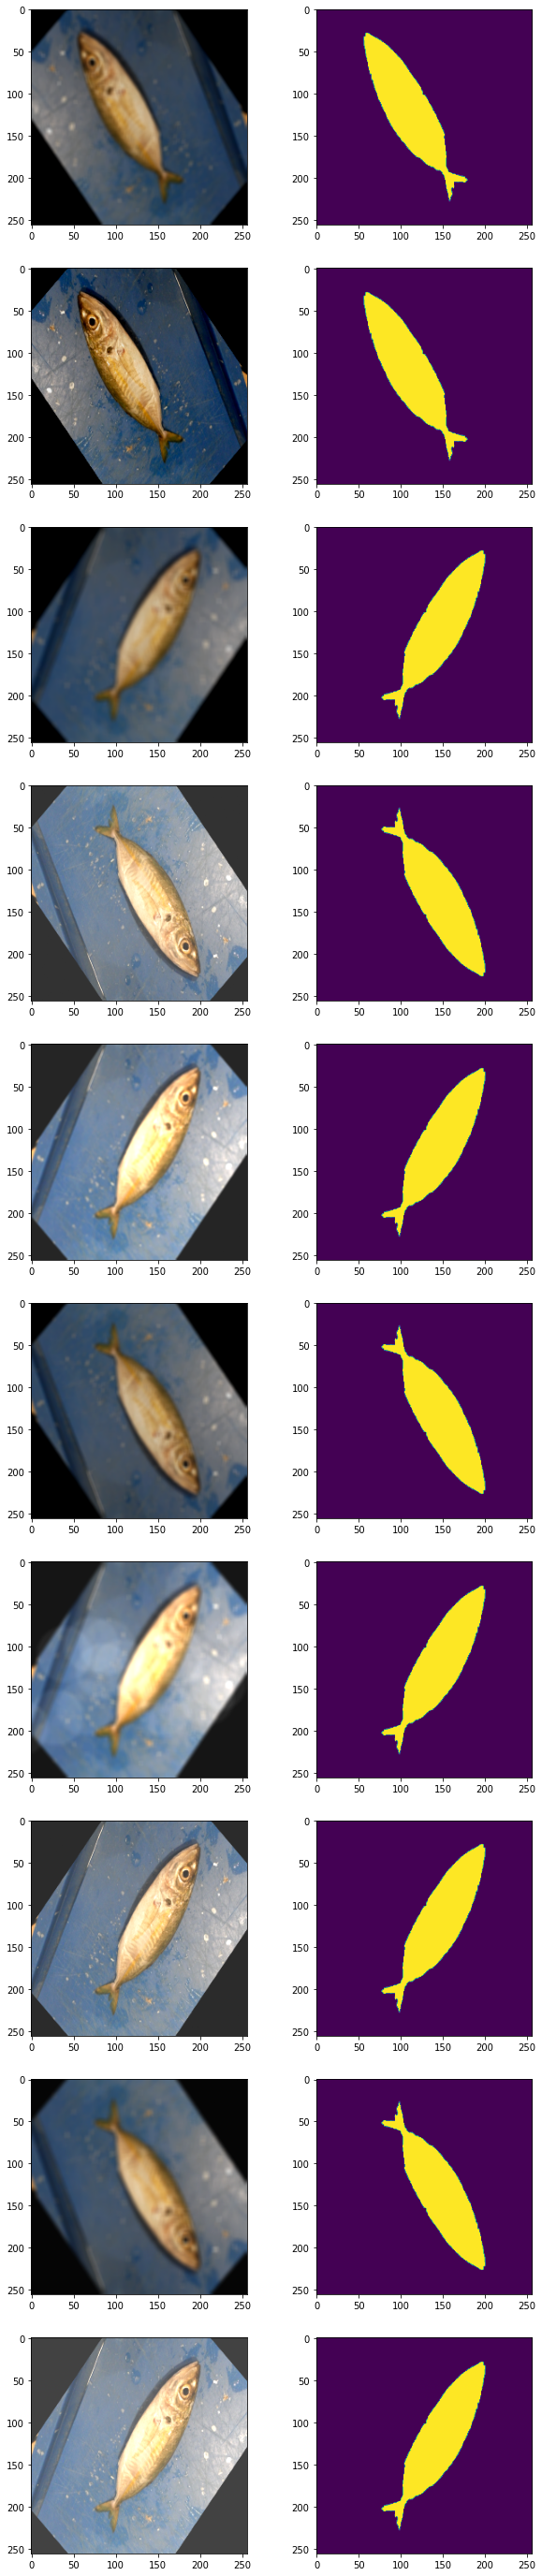

In [42]:
fig, axes = plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    item = dataset[0]
        
    axes[i, 0].imshow(item.image.permute(1, 2, 0).numpy().reshape(256, 256, 3))
    axes[i, 1].imshow(item.mask.numpy().reshape(256, 256))

In [43]:
train_dataset, test_dataset = train_test_split(dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False)

In [56]:
class Trainer:
    def __init__(self, model, criterion, optimizer, project, output_path, scheduler=None, config={}, device="cpu"):
        self.__model = model
        self.__criterion = criterion
        self.__optimizer = optimizer
        self.__scheduler = scheduler,
        self.__project = project
        self.__device = device
        self.__output_path = output_path
        self.__config = config
        
    def evaluate(self, loader):
        self.__model.to(self.__device)
        loader_length = len(loader)
        loss = 0
        with torch.no_grad():
            for batch in loader:
                torch.cuda.empty_cache()
                
                images = batch["image"].to(self.__device)
                masks = batch["mask"].cpu()
                
                outputs = model(images).cpu()
                batch_loss = self.__criterion(outputs, masks)
                loss += batch_loss.item()
            
        loss /= loader_length
        return loss
    
    def fit(self, loader, validation_loader=None, epochs=10):
        with wandb.init(project=self.__project, config=self.__config):
            wandb.watch(self.__model, self.__criterion, log="all")
            self.__model.to(self.__device)
            loader_length = len(loader)
            for epoch in range(epochs):
                loop = tqdm(loader)
                loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                epoch_loss = 0
                for batch in loop:
                    torch.cuda.empty_cache()
                    self.__optimizer.zero_grad()

                    images = batch["image"].to(self.__device)
                    masks = batch["mask"].cpu()

                    outputs = self.__model(images).cpu()
                    batch_loss = self.__criterion(outputs, masks)

                    epoch_loss += batch_loss.item()
                    loop.set_postfix(loss=batch_loss.item())

                    batch_loss.backward()
                    self.__optimizer.step()



                epoch_loss /= loader_length
                loop.set_postfix(loss=epoch_loss)
                wandb.log({"loss": epoch_loss}, step=epoch+1)

                if validation_loader is not None:
                    validation_loss = self.evaluate(validation_loader)
                    loop.set_postfix(validation_loss=validation_loss)
                    wandb.log({"validation_loss": validation_loss}, step=epoch+1)

                    if self.__scheduler is not None:
                        scheduler.step(validation_loss)
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                else:
                    if self.__scheduler is not None:
                        scheduler.step()
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                        
            torch.onnx.export(model, images, self.__output_path)
            wandb.save(self.__output_path)

In [57]:
if train_config.model.type == "UNet":
    model = smp.Unet(**train_config.model.parameters)
    
if train_config.criterion == "BCE":
    criterion = nn.BCEWithLogitsLoss()

if train_config.optimizer.type == "AdamW":
    optimizer = AdamW(model.parameters(), **train_config.optimizer.parameters)
    
    
if "scheduler" in train_config:
    if train_config.scheduler.type == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, **train_config.scheduler.parameters)
else:
    scheduler = None
    
trainer = Trainer(model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  device=train_config.device,
                  project=train_config.project,
                  output_path=train_config.output_path,
                  config=train_config)

In [58]:
trainer.fit(loader=train_loader, validation_loader=test_loader, epochs=train_config.epochs)

wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch [10/10]: 100%|██████████| 450/450 [02:37<00:00,  2.86it/s, loss=0.0441]


In [62]:
test_loss = trainer.evaluate(test_loader)
test_loss

0.04811026195162221

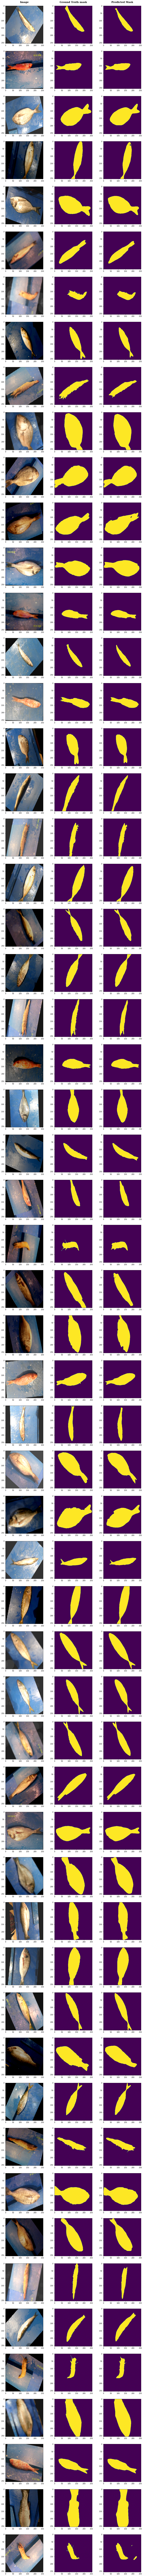

In [77]:
model.to(train_config.device)

test_length = len(test_loader)

fig, axes = plt.subplots(test_length, 3, figsize=(3*5, test_length * 5))
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        torch.cuda.empty_cache()
                
        images = batch["image"].to(train_config.device)
        masks = batch["mask"].cpu()
                
        outputs = model(images).cpu()
        
        image, mask, predicted_mask = images.cpu()[0].permute(1, 2, 0).numpy(), masks[0].permute(1, 2, 0).numpy(), outputs[0].permute(1, 2, 0).numpy()
        binary_predicted_mask = np.where(predicted_mask > 0.5, 1, 0)
        
        image_ax, mask_ax, predicted_mask_ax = axes[idx, 0], axes[idx, 1], axes[idx, 2]
        
        image_ax.imshow(image)
        mask_ax.imshow(mask)
        predicted_mask_ax.imshow(binary_predicted_mask)
        
        
        if idx == 0:
            image_ax.set_title("Image", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            mask_ax.set_title("Ground Truth mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            predicted_mask_ax.set_title("Predicted Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        
        
fig.show()